In [1]:
%cd ..

/nfs/scistore16/edelgrp/fzimin/depth-poset


/mnt/nfs/clustersw/Debian/bookworm/jupyterhub/1.0/lib/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import os
import subprocess

import numpy as np
import pandas as pd
import pickle as pkl
import networkx as nx
import gudhi as gh

from src.depth import DepthPoset


#from tqdm.notebook import tqdm
from tqdm import tqdm

from matplotlib import pyplot as plt
from matplotlib import cm
from networkx import draw_networkx
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from matplotlib import lines as mlines
from matplotlib.colors import to_rgb

from src import poset_scores, node_scores

import itertools


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.0 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/mnt/nfs/clustersw/Debian/bookworm/jupyterhub/1.0/lib/python3.11/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/mnt/nfs/clustersw/Debian/bookworm/jupyterhub/1.0/lib/python3.11/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/mnt/nfs/clustersw/Debian/bookworm/jupyterhub/1.0/lib/python3.11/site-packages/ipykern

AttributeError: _ARRAY_API not found

# Create directory for the pics

In [3]:
pics_path = 'raports/pics/extended torus scores'

if not os.path.exists(pics_path):
    os.makedirs(pics_path)

# Load and Format the Data

In [4]:
# define file paths
directory = "results/scores-on-barycentric-cubical-toruses-extended"
paths = np.sort([f'{directory}/{f}' for f in os.listdir(directory)])


In [5]:
df_sizes = pd.DataFrame({'path': paths})
df_sizes['size'] = df_sizes['path'].apply(lambda path: os.path.getsize(path))

print(f"Total Size is {df_sizes['size'].sum()*1024**-3:.4f} GB.")
print(f"The distribution of sizes:\n{df_sizes['size'].describe()}")

Total Size is 0.0785 GB.
The distribution of sizes:
count    5.400000e+02
mean     1.560380e+05
std      3.005106e+05
min      1.830000e+03
25%      8.385000e+03
50%      1.495650e+04
75%      1.343148e+05
max      1.510149e+06
Name: size, dtype: float64


In [6]:

#paths = paths[pd.Series(paths).apply(lambda s: s.split('.')[0].split('/')[-1]).values > '2024-12-26 18:04:00']

# load them
ls = []
for path in tqdm(paths, total=len(paths)):
    with open(path, 'rb') as file:
        ls.append(pkl.load(file))
        ls[-1].update({'path': path})

100%|██████████| 540/540 [00:04<00:00, 112.60it/s]


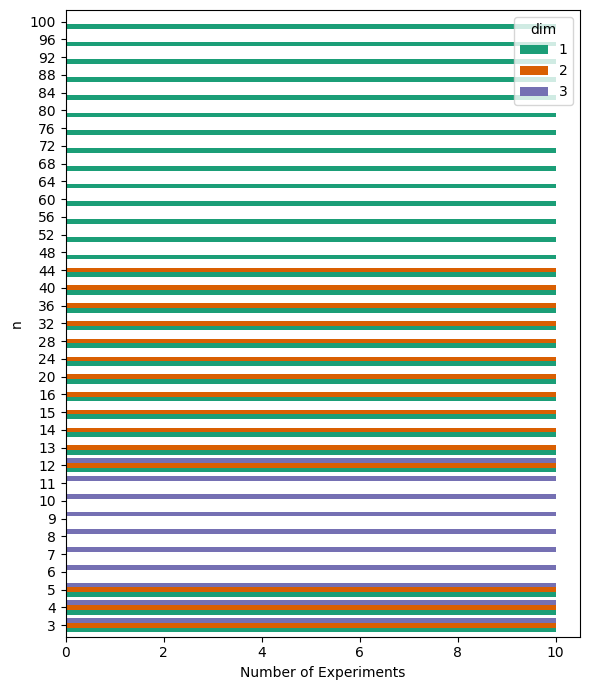

In [7]:
fig, ax = plt.subplots(figsize=(6, 7))

df_cases = pd.DataFrame(ls)
df_cases.insert(0, 'index', df_cases.index)


cmap_categorical = plt.get_cmap('Dark2')
colors = cmap_categorical(np.arange(df_cases['dim'].nunique()))

df_cases[['n', 'dim', 'depth poset']].groupby(['n', 'dim']).count().reset_index().pivot(columns='dim', index='n', values='depth poset').fillna(0).astype(int).plot(kind='barh', width=0.8, ax=ax, color=colors)
plt.xlabel('Number of Experiments')
plt.tight_layout()
plt.savefig('raports/pics/torus scores/cases.png')

In [8]:
print(f'df_cases.shape = {df_cases.shape}')
df_cases.head()

df_cases.shape = (540, 9)


,index,n,dim,shape,complex,depth poset,poset scores,node scores,path
0,0,9,3,"(9, 9, 9)",<src.complexes.CubicalTorusComplexExtended obj...,<src.depth.DepthPoset object at 0x7f1cf3515510>,"[{'object': 'full', 'cycles_dimension': 1938, ...","[{'object': 'full', 'node': (7, 7, 4),((7,7,4)...",results/scores-on-barycentric-cubical-toruses-...
1,1,9,3,"(9, 9, 9)",<src.complexes.CubicalTorusComplexExtended obj...,<src.depth.DepthPoset object at 0x7f1cf434abd0>,"[{'object': 'full', 'cycles_dimension': 1735, ...","[{'object': 'full', 'node': (7, 5, 7),((7,5,7)...",results/scores-on-barycentric-cubical-toruses-...
2,2,9,3,"(9, 9, 9)",<src.complexes.CubicalTorusComplexExtended obj...,<src.depth.DepthPoset object at 0x7f1cf31bd110>,"[{'object': 'full', 'cycles_dimension': 1776, ...","[{'object': 'full', 'node': (4, 4, 3),((4,4,3)...",results/scores-on-barycentric-cubical-toruses-...
3,3,9,3,"(9, 9, 9)",<src.complexes.CubicalTorusComplexExtended obj...,<src.depth.DepthPoset object at 0x7f1cf2deb350>,"[{'object': 'full', 'cycles_dimension': 1743, ...","[{'object': 'full', 'node': (0, 6, 8),((0,6,8)...",results/scores-on-barycentric-cubical-toruses-...
4,4,9,3,"(9, 9, 9)",<src.complexes.CubicalTorusComplexExtended obj...,<src.depth.DepthPoset object at 0x7f1cf2d1a490>,"[{'object': 'full', 'cycles_dimension': 1956, ...","[{'object': 'full', 'node': (1, 2, 4),((1,2,4)...",results/scores-on-barycentric-cubical-toruses-...


### Listing the cases which are not exactly 10 experiments.

In [9]:
df_cases_not10 = df_cases.groupby(['n', 'dim']).agg({'index': 'count', 'path': list}).rename(columns={'index': 'count'})
df_cases_not10 = df_cases_not10[df_cases_not10['count'] != 10] 
df_cases_not10 = df_cases_not10.explode('path').reset_index()
df_cases_not10

,n,dim,count,path


In [10]:
print('\n'.join(df_cases_not10['path'].apply(lambda s: f'rm "{s}"')))

# The example of the filtration $f: \mathbb{T}^2\to\mathbb{R}$

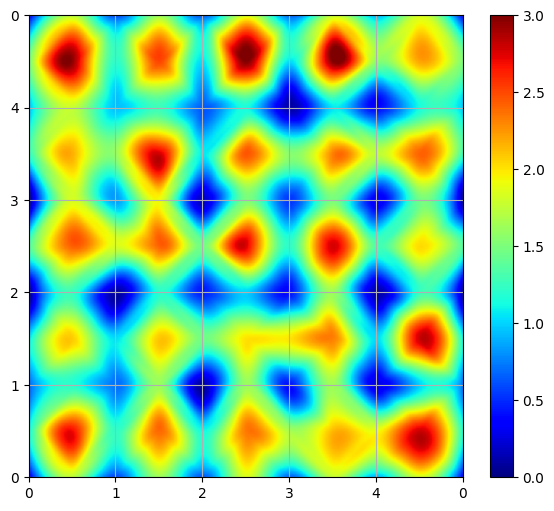

In [11]:
try:
    ctc = np.random.choice(df_cases[(df_cases['dim'] == 2)&(df_cases['n'] <= 6)]['complex'])
except ValueError:
    ctc = np.random.choice(df_cases[(df_cases['dim'] == 2)]['complex'])
    
n = ctc.shape[0]

fig, ax = plt.subplots(figsize=(7, 6))

sm = ctc.draw_gradiental(ax=ax, vmin=0, vmax=3, cmap='jet')
plt.colorbar(sm, ax=ax)

ax.set_xticks(np.arange(n + 1), np.arange(n + 1)%n)
ax.set_yticks(np.arange(n + 1), np.arange(n + 1)%n)
ax.grid(True)

plt.savefig(os.path.join(pics_path, '2d-example.png'))

# Plot Poset Scores

## Define Scores and Objects Distribution

In [12]:
def get_object_reduction(s):
    if s.find('row reduction') == 0:
        return 'row reduction'
    elif s.find('column reduction') == 0:
        return 'column reduction'
    else:
        return 'full'

In [13]:
df_scores = df_cases[['index', 'n', 'dim', 'poset scores']]
df_scores = df_scores.explode('poset scores')
df_scores = pd.concat([df_scores.drop(columns='poset scores'), df_scores['poset scores'].apply(pd.Series)], axis=1)
df_scores['reduction'] = df_scores['object'].apply(get_object_reduction)

print(f'df_scores.shape = {df_scores.shape}')
df_scores.head()

df_scores.shape = (4290, 12)


,index,n,dim,object,cycles_dimension,height,number_of_nodes,number_of_relations,number_of_components,number_of_maximal_nodes,number_of_minimal_nodes,reduction
0,0,9,3,full,1938.0,26.0,2916.0,4734.0,NaN,NaN,NaN,full
0,0,9,3,subposet dim=0,129.0,9.0,728.0,798.0,NaN,NaN,NaN,full
0,0,9,3,subposet dim=1,1689.0,26.0,1458.0,3139.0,NaN,NaN,NaN,full
0,0,9,3,subposet dim=2,120.0,11.0,728.0,797.0,NaN,NaN,NaN,full
0,0,9,3,column reduction,NaN,NaN,NaN,NaN,NaN,NaN,NaN,column reduction


In [14]:
df_scores[df_scores['object'] == 'column reduction']

,index,n,dim,object,cycles_dimension,height,number_of_nodes,number_of_relations,number_of_components,number_of_maximal_nodes,number_of_minimal_nodes,reduction
0,0,9,3,column reduction,NaN,NaN,NaN,NaN,NaN,NaN,NaN,column reduction
1,1,9,3,column reduction,NaN,NaN,NaN,NaN,NaN,NaN,NaN,column reduction
2,2,9,3,column reduction,NaN,NaN,NaN,NaN,NaN,NaN,NaN,column reduction
3,3,9,3,column reduction,NaN,NaN,NaN,NaN,NaN,NaN,NaN,column reduction
4,4,9,3,column reduction,NaN,NaN,NaN,NaN,NaN,NaN,NaN,column reduction
...,...,...,...,...,...,...,...,...,...,...,...,...
535,535,44,2,column reduction,NaN,NaN,NaN,NaN,591.0,856.0,2318.0,column reduction
536,536,44,2,column reduction,NaN,NaN,NaN,NaN,629.0,882.0,2315.0,column reduction
537,537,44,2,column reduction,NaN,NaN,NaN,NaN,683.0,934.0,2319.0,column reduction
538,538,44,2,column reduction,NaN,NaN,NaN,NaN,701.0,935.0,2317.0,column reduction


In [15]:
df_done_scores = df_scores.groupby(['dim', 'reduction']).count().drop(columns=['index', 'n', 'object']) > 0
df_done_scores = df_done_scores.loc[itertools.product(df_cases['dim'].unique(), ['full', 'row reduction', 'column reduction'])]
df_done_scores

cycles_dimension  height  number_of_nodes  \
dim reduction                                                     
3   full                          True    True             True   
    row reduction                False   False            False   
    column reduction             False   False            False   
1   full                          True    True             True   
    row reduction                False   False            False   
    column reduction             False   False            False   
2   full                          True    True             True   
    row reduction                False   False            False   
    column reduction             False   False            False   

                      number_of_relations  number_of_components  \
dim reduction                                                     
3   full                             True                 False   
    row reduction                   False                 False   
    column reduction                False                 False   
1   full                             True                 False   
    row reduction                   False                 False   
    column reduction                False                 False   
2   full                             True                  True   
    row reduction                   False                  True   
    column reduction                False                  True   

                      number_of_maximal_nodes  number_of_minimal_nodes  
dim reduction                                                           
3   full                                False                    False  
    row reduction                       False                    False  
    column reduction                    False                    False  
1   full                                False                    False  
    row reduction                       False                    False  
    column reduction                    False                    False  
2   full                                 True                     True  
    row reduction                        True                     True  
    column reduction                     True                     True

## Plot scores

In [16]:
df_objects_scores = df_done_scores.stack()
df_objects_scores = df_objects_scores[df_objects_scores].index.to_series().reset_index(drop=False).drop(columns=0).rename(columns={'level_2': 'score'})
df_objects_scores = df_objects_scores.sort_values('score').reset_index(drop=True)

print(f'There are {len(df_objects_scores)} score object pairs to plot')
df_objects_scores.head()

There are 21 score object pairs to plot


,dim,reduction,score
0,3,full,cycles_dimension
1,1,full,cycles_dimension
2,2,full,cycles_dimension
3,3,full,height
4,1,full,height


In [17]:
def get_score_path(score, dim, reduction, score_filename_template='score={score}, dim={dim}, object={reduction}.png'):
    # returns path to saved and load a picture about the object
    return os.path.join(pics_path, score_filename_template.format(score=score, dim=dim, reduction=reduction).replace('_', '-'))

100%|██████████| 21/21 [00:03<00:00,  6.22it/s]


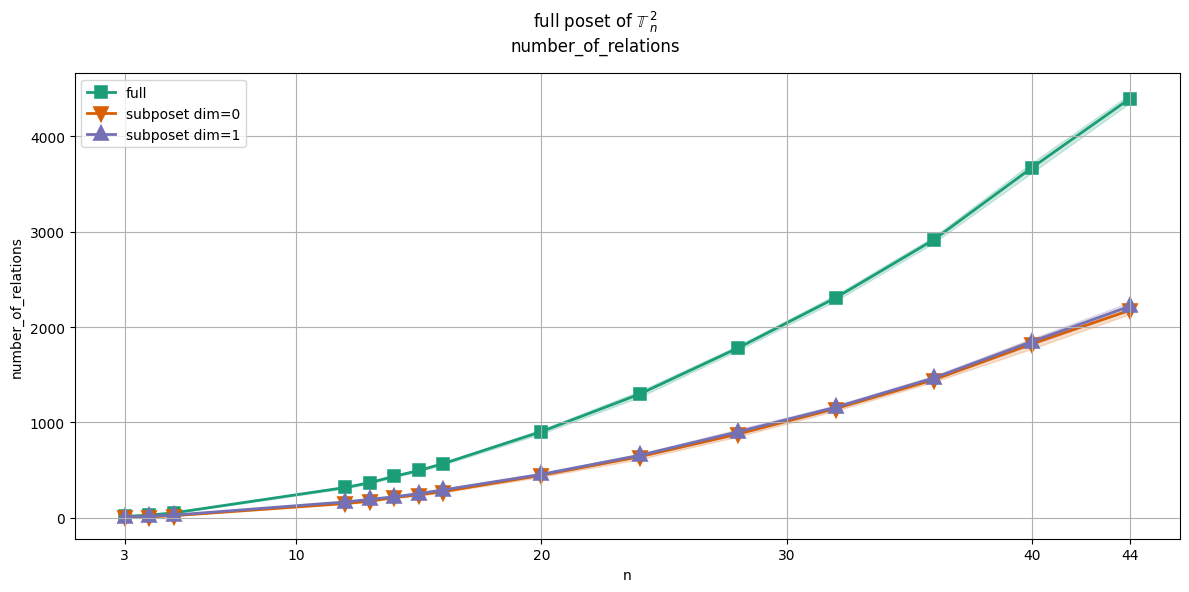

In [18]:
markers = ['s', 'v', '^', 'o', '*']


for i, row in tqdm(df_objects_scores.iterrows(), total=len(df_objects_scores)):
    path = get_score_path(**row)
    
    score = row['score']

    df_score = df_scores[(df_scores['dim'] == row['dim']) & (df_scores['reduction'] == row['reduction'])][['index', 'n', 'object', score]]
    df_score = df_score.pivot_table(index=['n', 'index'], columns='object', values=score).reset_index(drop=False).drop(columns='index')

    df_score_mean = df_score.groupby('n').mean()
    df_score_std = df_score.groupby('n').std()

    colors = cmap_categorical(np.arange(df_score_mean.shape[1]))
    
    fig, ax = plt.subplots(figsize=(12, 6))

    for i_col, col in enumerate(df_score_mean.columns):
        linewidth = 2
        markeredgewidth = 4
        x_mean = df_score_mean.index
        y_mean = df_score_mean[col]
        y_std = df_score_std[col]
        ax.plot(x_mean, y_mean, label=col, color=colors[i_col], marker=markers[i_col], linewidth=linewidth, markeredgewidth=markeredgewidth, zorder=1)
        ax.fill_between(x_mean, y_mean - y_std, y_mean + y_std, color=colors[i_col], alpha=0.2, zorder=0)

    xticks = ax.get_xticks().astype(int)
    xticks = np.concatenate([xticks[(xticks > x_mean.min())&(xticks < x_mean.max())], [x_mean.min(), x_mean.max()]]).astype(int)
    xticks = np.unique(xticks)
    ax.set_xticks(xticks)

    ax.legend()
    ax.set_xlabel('n')    
    ax.set_ylabel(score)
    ax.grid(True)

    plt.savefig(path)

    if i < len(df_objects_scores) - 1:
        plt.close()

#    else:
plt.suptitle(f"{row['reduction']} poset of $\mathbb{{T\;}}_n^{{{row['dim']}}}$\n{score}")
plt.tight_layout()
plt.show()

# Reporting

## Scores

### Scores Description

In [19]:
def latexize_the_score(score):
    return score.replace('_', r'\_')

In [20]:
ltx_scores_description = [
    f"""
    \\item \\textbf{{{latexize_the_score(score)}}} - {getattr(poset_scores, score).__doc__.strip()}
    """.strip()
    for score in df_objects_scores['score'].unique()
]
ltx_scores_description = '\n'.join(ltx_scores_description)
ltx_scores_description = f"""
\\par We have computed the following scores for the objects in the depth poset of the extended barycentric cubical torus:
\\begin{{itemize}}
{ltx_scores_description}
\\end{{itemize}}
""".strip()

print(ltx_scores_description)

\par We have computed the following scores for the objects in the depth poset of the extended barycentric cubical torus:
\begin{itemize}
\item \textbf{cycles\_dimension} - Returns the dimension of space of cycles in reduction.
\item \textbf{height} - Returns the poset height - the length of the longest chain.
\item \textbf{number\_of\_components} - Returns the number of connetcted components in the poset
\item \textbf{number\_of\_maximal\_nodes} - Returns the number of maximal nodes.
\item \textbf{number\_of\_minimal\_nodes} - Returns the number of minimal nodes.
\item \textbf{number\_of\_nodes} - Returns the number of nodes in the poset.
\item \textbf{number\_of\_relations} - Returns the number of relations in the transitive reduction.
\end{itemize}


## Scores Table

In [21]:
def get_score_label(score, dim, reduction, score_label_template='{score}-{reduction}{dim}'):
    # returns label to saved and load a picture about the object
    return 'fig:' + score_label_template.format(score=score, dim=dim, reduction=reduction).replace('_', '').replace(' ', '')

In [22]:
df_done_scores_pics = pd.DataFrame(
    [[f'Fig. \\ref{{{get_score_label(score, dim, reduction)}}}' for score in df_done_scores.columns] for dim, reduction in df_done_scores.index],
    index=df_done_scores.index,
    columns=df_done_scores.columns
)
df_done_scores_pics[~df_done_scores] = np.nan
df_done_scores_pics = df_done_scores_pics.dropna(how='all').fillna('')
df_done_scores_pics.columns = df_done_scores_pics.columns.str.replace('_', r'\_')

df_done_scores_pics = df_done_scores_pics.transpose()

df_done_scores_pics

dim                                                              3  \
reduction                                                     full   
cycles\_dimension             Fig. \ref{fig:cyclesdimension-full3}   
height                                 Fig. \ref{fig:height-full3}   
number\_of\_nodes               Fig. \ref{fig:numberofnodes-full3}   
number\_of\_relations       Fig. \ref{fig:numberofrelations-full3}   
number\_of\_components                                               
number\_of\_maximal\_nodes                                           
number\_of\_minimal\_nodes                                           

dim                                                              1  \
reduction                                                     full   
cycles\_dimension             Fig. \ref{fig:cyclesdimension-full1}   
height                                 Fig. \ref{fig:height-full1}   
number\_of\_nodes               Fig. \ref{fig:numberofnodes-full1}   
number\_of\_relations       Fig. \ref{fig:numberofrelations-full1}   
number\_of\_components                                               
number\_of\_maximal\_nodes                                           
number\_of\_minimal\_nodes                                           

dim                                                                 2  \
reduction                                                        full   
cycles\_dimension                Fig. \ref{fig:cyclesdimension-full2}   
height                                    Fig. \ref{fig:height-full2}   
number\_of\_nodes                  Fig. \ref{fig:numberofnodes-full2}   
number\_of\_relations          Fig. \ref{fig:numberofrelations-full2}   
number\_of\_components        Fig. \ref{fig:numberofcomponents-full2}   
number\_of\_maximal\_nodes  Fig. \ref{fig:numberofmaximalnodes-full2}   
number\_of\_minimal\_nodes  Fig. \ref{fig:numberofminimalnodes-full2}   

dim                                                                            \
reduction                                                       row reduction   
cycles\_dimension                                                               
height                                                                          
number\_of\_nodes                                                               
number\_of\_relations                                                           
number\_of\_components        Fig. \ref{fig:numberofcomponents-rowreduction2}   
number\_of\_maximal\_nodes  Fig. \ref{fig:numberofmaximalnodes-rowreduction2}   
number\_of\_minimal\_nodes  Fig. \ref{fig:numberofminimalnodes-rowreduction2}   

dim                                                                            
reduction                                                    column reduction  
cycles\_dimension                                                              
height                                                                         
number\_of\_nodes                                                              
number\_of\_relations                                                          
number\_of\_components      Fig. \ref{fig:numberofcomponents-columnreducti...  
number\_of\_maximal\_nodes  Fig. \ref{fig:numberofmaximalnodes-columnreduc...  
number\_of\_minimal\_nodes  Fig. \ref{fig:numberofminimalnodes-columnreduc...

In [23]:
ltx_scores_table = f"""
\\par We can see the score values in the following figures:
\\begin{{center}}
{df_done_scores_pics.to_latex()}
\\end{{center}}
""".strip()

print(ltx_scores_table)

\par We can see the score values in the following figures:
\begin{center}
\begin{tabular}{llllll}
\toprule
dim & 3 & 1 & \multicolumn{3}{r}{2} \\
reduction & full & full & full & row reduction & column reduction \\
\midrule
cycles\_dimension & Fig. \ref{fig:cyclesdimension-full3} & Fig. \ref{fig:cyclesdimension-full1} & Fig. \ref{fig:cyclesdimension-full2} &  &  \\
height & Fig. \ref{fig:height-full3} & Fig. \ref{fig:height-full1} & Fig. \ref{fig:height-full2} &  &  \\
number\_of\_nodes & Fig. \ref{fig:numberofnodes-full3} & Fig. \ref{fig:numberofnodes-full1} & Fig. \ref{fig:numberofnodes-full2} &  &  \\
number\_of\_relations & Fig. \ref{fig:numberofrelations-full3} & Fig. \ref{fig:numberofrelations-full1} & Fig. \ref{fig:numberofrelations-full2} &  &  \\
number\_of\_components &  &  & Fig. \ref{fig:numberofcomponents-full2} & Fig. \ref{fig:numberofcomponents-rowreduction2} & Fig. \ref{fig:numberofcomponents-columnreduction2} \\
number\_of\_maximal\_nodes &  &  & Fig. \ref{fig:numberof

### Score pics

In [24]:
hspace_width = -0.24
width = 1.4

ltx_score_pics = [
    ' '*4 + f"""
    \\begin{{figure}}[h!]
        \\centering
        \\hspace*{{{hspace_width}\\textwidth}}
        \\includegraphics[width={width}\\textwidth]{{{get_score_path(**row).replace('raports/', '')}}}
        \\caption{{Score {latexize_the_score(row['score'])} values for the {row['reduction']} poset of $\\mathbb{{T}}_n^{{{row['dim']}}}$.}}
        \\label{{{get_score_label(**row)}}}
    \\end{{figure}}
    """.strip() for i, row in df_objects_scores.iterrows()
]

ltx_score_pics = '\n'.join(ltx_score_pics)
print(ltx_score_pics)

    \begin{figure}[h!]
        \centering
        \hspace*{-0.24\textwidth}
        \includegraphics[width=1.4\textwidth]{pics/extended torus scores/score=cycles-dimension, dim=3, object=full.png}
        \caption{Score cycles\_dimension values for the full poset of $\mathbb{T}_n^{3}$.}
        \label{fig:cyclesdimension-full3}
    \end{figure}
    \begin{figure}[h!]
        \centering
        \hspace*{-0.24\textwidth}
        \includegraphics[width=1.4\textwidth]{pics/extended torus scores/score=cycles-dimension, dim=1, object=full.png}
        \caption{Score cycles\_dimension values for the full poset of $\mathbb{T}_n^{1}$.}
        \label{fig:cyclesdimension-full1}
    \end{figure}
    \begin{figure}[h!]
        \centering
        \hspace*{-0.24\textwidth}
        \includegraphics[width=1.4\textwidth]{pics/extended torus scores/score=cycles-dimension, dim=2, object=full.png}
        \caption{Score cycles\_dimension values for the full poset of $\mathbb{T}_n^{2}$.}
        \label{fig

## Load texts

In [25]:
# load texts, describing the process
with open('texts/barycentric-cubical-torus - model.txt', 'r') as file:
    ltx_model = file.read()

with open('texts/barycentric-cubical-torus - model extension.txt', 'r') as file:
    ltx_model_ext = file.read()

# load LaTeX template
with open('texts/template.tex', 'r') as file:
    ltx_latex = file.read()

In [26]:
body = f"""
\\section{{Model}}
{ltx_model}
{ltx_model_ext}

\\section{{Poset Scores}}
\\subsection{{Scores Description}}
{ltx_scores_description}
\\subsection{{Scores}}
{ltx_scores_table}
{ltx_score_pics}
"""


raport = ltx_latex.replace('BODY', body)
print(raport)

\documentclass{article}
\usepackage{amsfonts} 
\usepackage{amsmath}
\usepackage{hyperref}
\usepackage{graphicx}
\usepackage{subcaption}
\usepackage{booktabs}
\usepackage{makecell}
\usepackage{multirow}
%\usepackage{placeins}

\begin{document}


\section{Model}
\par The $d$ dimensional torus $\mathbb{T}^d$ can be defined as $\left(\mathbb{R}/n\mathbb{Z}\right)^d$ for some natural $n$. And we can represent this as a cell-complex with cubical $d$-dimensional cells $\left(\mathbb{Z}/n\mathbb{Z}\right)^d + [0, 1]^d$ and all their $k$-faces for $k=0, ..., d$.
\par We randomly assume the filtration value for each $k$-face uniformly distributed in $[k, k+1]$. This filtration on segmented torus will corespond some real filtration $f: mathbb{T}^d\to\mathbb{R}$, s.t. the $d$-dimensional cells will corespond the local maximums, vertices will corespond the local minimums and other $k$-faces will be saddles.
\begin{figure}[h!]
    \centering
    \includegraphics[width=0.6\textwidth]{pics/torus score

In [27]:
with open('raports/barycentric-torus-extended-scores.tex', 'w') as file:
    file.write(raport)

In [28]:
os.chdir('raports')
result = subprocess.run(
    ['pdflatex', 'barycentric-torus-extended-scores.tex'],
    stdout=subprocess.PIPE,
    stderr=subprocess.PIPE,
    text=True  # или encoding='utf-8'
)
os.chdir('..')